# THANKS TO...

### This notebook visualizes an idea proposed by [**Onur Koç**](https://www.linkedin.com/in/onur-koç-a8732611b) during a meeting. The concept belongs to him.

## Decision Tree Classifier: NEW APPORACH FOR THRESHOLDS

In this notebook, we test a trick by manually choosing thresholds instead of simply taking the average.

### Special Trick: Better Threshold with "Shift"

In our `best_split` function, we use a **"shift"** adjustment when picking the threshold between two feature values.  
This helps choose a smarter split point when the class distribution is not balanced.

This is important:
Instead of picking the exact midpoint, we shift it slightly towards the side that needs more separation.  
This makes the split **more fair and accurate**, especially for imbalanced data.

Finally, we plot both models' accuracy as depth increases. (up to max depth, 20)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv("classification_dataset_2features.csv")

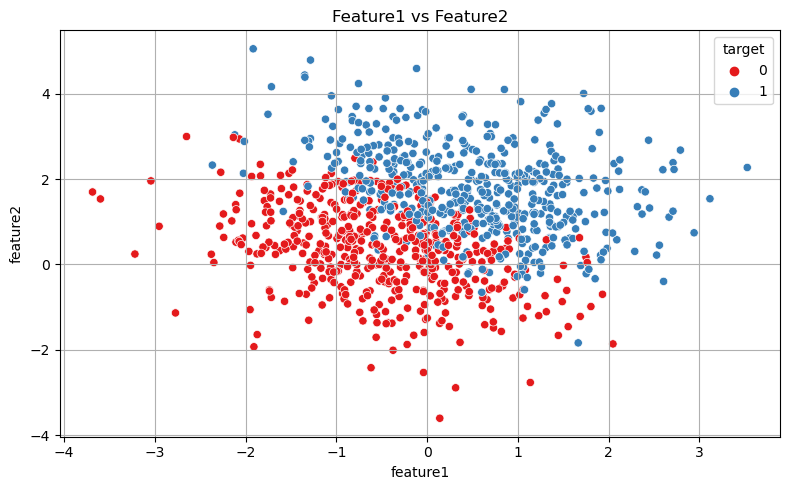

In [3]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='feature1', y='feature2', hue='target', palette='Set1')
plt.title('Feature1 vs Feature2')
plt.grid(True)
plt.tight_layout()
plt.show()

# New Approach

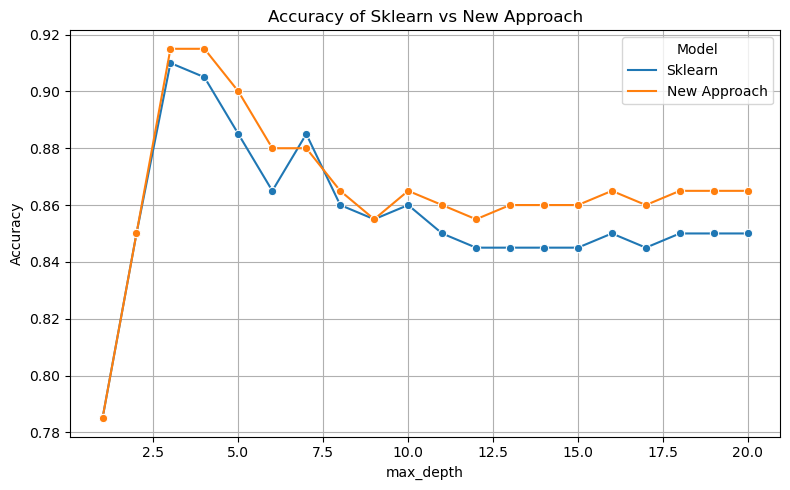

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def gini(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs**2)

def best_split(X, y):
    best_score, best_feat, best_thresh = float("inf"), None, None

    for i in range(X.shape[1]):
        vals = X[:, i]
        sorted_idx = np.argsort(vals)
        vals, targets = vals[sorted_idx], y[sorted_idx]

        for j in range(1, len(vals)):
            xl, xr = vals[j - 1], vals[j]
            if xl == xr: continue

            yl, yr = targets[:j], targets[j:]
            if len(yl) == 0 or len(yr) == 0: continue

            dl, dr = np.bincount(yl, minlength=2).max(), np.bincount(yr, minlength=2).max()
            total = dl + dr
            if total == 0: continue

####################################################################################################################
            
            shift = np.clip((dr - dl) / total, -0.5, 0.5)
            t = xl + (0.5 + shift) * (xr - xl)

####################################################################################################################

            left, right = X[:, i] < t, X[:, i] >= t
            if not left.any() or not right.any(): continue

            score = (left.sum() * gini(y[left]) + right.sum() * gini(y[right])) / len(y)
            if score < best_score:
                best_score, best_feat, best_thresh = score, i, t

    return best_feat, best_thresh

def build_tree(X, y, depth, level=0):
    if level == depth or len(np.unique(y)) == 1:
        return {'leaf': True, 'predict': np.round(np.mean(y))}

    feat, thresh = best_split(X, y)
    if feat is None:
        return {'leaf': True, 'predict': np.round(np.mean(y))}

    left = X[:, feat] < thresh
    right = ~left

    return {
        'leaf': False,
        'feat': feat,
        'thresh': thresh,
        'left': build_tree(X[left], y[left], depth, level + 1),
        'right': build_tree(X[right], y[right], depth, level + 1)
    }

def predict(tree, X):
    preds = []
    for row in X:
        node = tree
        while not node['leaf']:
            node = node['left'] if row[node['feat']] < node['thresh'] else node['right']
        preds.append(node['predict'])
    return np.array(preds)

X = df[['feature1', 'feature2']].values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

depths = list(range(1, 21))
acc_sklearn, acc_manual = [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42).fit(X_train, y_train)
    acc_sklearn.append(accuracy_score(y_test, clf.predict(X_test)))

    tree = build_tree(X_train, y_train, depth=d)
    acc_manual.append(accuracy_score(y_test, predict(tree, X_test)))

df_plot = pd.DataFrame({'max_depth': depths, 'Sklearn': acc_sklearn, 'New Approach': acc_manual})
df_plot = df_plot.melt(id_vars='max_depth', var_name='Model', value_name='Accuracy')

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_plot, x='max_depth', y='Accuracy', hue='Model', marker='o')
plt.title('Accuracy of Sklearn vs New Approach')
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion

New approach works well.  
It gives better accuracy than Scikit-Learn Decision Tree Classifier.  
This means Onur's method is correct and useful.